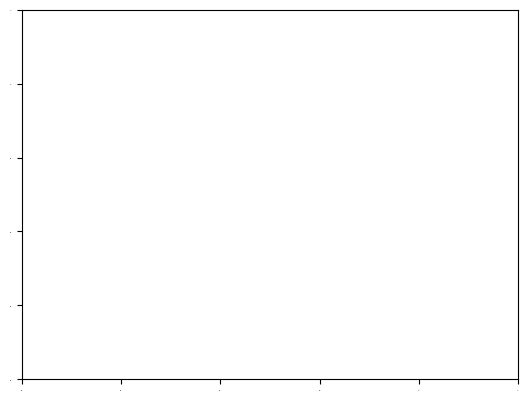

In [16]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from pathlib import Path
from matplotlib.ticker import ScalarFormatter
from os.path import join
from shapely.geometry import box
import warnings
from shapely.ops import unary_union
from matplotlib.lines import Line2D

fontsize = 8
# plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['font.size'] = fontsize
plt.rcParams['legend.fontsize'] = fontsize
plt.tick_params(axis='both', labelsize=1)

In [2]:
manual_label_dir = "/net/data_ssd/tree_mortality_orthophotos/labels_and_aois/"
orthophoto_dir = "/net/data_ssd/tree_mortality_orthophotos/orthophotos/"
prediction_label_dir = "/net/data_ssd/tree_mortality_orthophotos/deadwood_segmentation_predictions_104//"

In [ ]:
orthophoto_base_names = ["auwald_flight_all_merge_ortho", "uavforsat_FIN003_ortho", "quebec_2021-07-21-sbl-cloutier-z1-rgb", "quebec_2021-06-17-sbl-cloutier-z2-rgb",
                        "switzerlandeth_rgb11"]
bls = [(51.37021264, 12.30362458), (60.2232, 24.914030093), (45.9885, -74.0042), (45.99451412, -74.00396778), (47.163719, 9.0713911)]
extents = [0.00068366, 0.00068366, 0.0004, 0.00025, 0.001]

fig, axes = plt.subplots(ncols=len(bls), figsize=(6*len(bls),6))

for basename, bl, extent, ax in zip(orthophoto_base_names, bls, extents, axes):
    label_path = join(manual_label_dir, basename + "_polygons.gpkg")
    orthophoto_path = join(orthophoto_dir, basename + ".tif")
    prediction_path = join(prediction_label_dir, basename + "_prediction.gpkg")
    
    dr = rasterio.open(orthophoto_path)

    print(dr.bounds)

    label = gpd.read_file(label_path, layer="standing_deadwood")
    try:
        label = pd.concat([label, gpd.read_file(label_path, layer="brown_trees")])
    except:
        pass
    try:
        label = pd.concat([label, gpd.read_file(label_path, layer="parts")])
    except:
        pass
        
    label = label.to_crs(dr.crs).buffer(0)
    prediction = gpd.read_file(prediction_path).to_crs(dr.crs).buffer(0)

    bounds_box = box(bl[1], bl[0], bl[1] + extent, bl[0] + extent)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # crop label and prediction to extend of image and unionize 
        label_union = label.union_all().intersection(bounds_box) 
        pred_union = prediction.union_all().intersection(bounds_box)
        TP_area = label_union.union(pred_union).area
        FP_area = pred_union.difference(label_union).area
        FN_area = label_union.difference(pred_union).area
        
    print(f"{TP_area=}, {FP_area=}, {FN_area=}")
    
    precision = TP_area / (TP_area + FP_area)
    recall = TP_area / (TP_area + FN_area)
    f1 = 2 * (precision * recall) / (precision + recall)

    print(f"{basename=}, {precision=}, {recall=}, {f1=}")

    ax.set_ylim((bl[0], bl[0] + extent))
    ax.set_xlim((bl[1], bl[1] + extent))
    win = dr.window(bl[1], bl[0], bl[1] + extent, bl[0] + extent) 
    ax.imshow(np.moveaxis(dr.read(window=win), 0, -1), extent=[bl[1], bl[1] + extent, bl[0], bl[0] + extent], vmin=0, vmax=255)
    
    label.boundary.plot(ax=ax, color="#ff7f0e", lw=2, alpha=1)
    prediction.boundary.plot(ax=ax, color="#1f77b4", lw=2, alpha=1)

    legend_elements = [Line2D([0], [0], color="#ff7f0e", label='Label'),
                     Line2D([0], [0], color="#1f77b4", label='Prediction')]
    ax.legend(handles=legend_elements)

    ax.set_aspect("equal")

BoundingBox(left=12.29364754940055, bottom=51.3643753256927, right=12.31170405674576, top=51.3765363186545)
